In [16]:
import pandas as pd
import numpy as np
import os

import sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.metrics import mean_squared_error

In [12]:
os.chdir("C:\\Users\\rohit\\anaconda3\\Scripts\\IML\\Kaggle")

In [13]:

def fn_knn(df_p, X, y, target):
    
    df_p = df_p.iloc[: , :-1]
      
    # Seperating numerical and categorical features
    X_num = X.select_dtypes(include='number')
    X_cat = X.select_dtypes(include='object')
    
    # Scaling numerical features
    s = MinMaxScaler()
    X_num_scaled = s.fit_transform(X_num)
    X_num_scaled = pd.DataFrame(X_num_scaled, columns=X_num.columns)
    
    # Label encoding on categotical features
    # Label encoder is accepting only 1d array, so I'm label encoding for each column and storing it in a dictionary
    X_encoded = pd.DataFrame({})
    my_le = {}
    for item in X_cat.columns:
        my_le[item] = LabelEncoder()
        X_encoded[item] = my_le[item].fit_transform(X_cat[item]) 
        
    # Concat scaled numerical and encoded categorical features
    X = pd.concat([X_encoded, X_num_scaled], axis=1) 
    
    # Seperating numerical and categorical of predication data set
    df_p_num = df_p.select_dtypes(include='number')
    df_p_cat = df_p.select_dtypes(include='object')

    # Scaling numerical features of prediction data set
    df_p_num_scaled = s.transform(df_p_num)
    df_p_num_scaled = pd.DataFrame(df_p_num_scaled, columns=df_p_num.columns)
    
    # Scaling categorical features of prediction data set
    # making sure that if male is taken as 1 in the earlier label encoding, the same (male=1) is taken now
    df_p_cat_encoded = pd.DataFrame({})
    for item in df_p_cat.columns:
        df_p_cat_encoded[item] = my_le[item].transform(df_p_cat[item]) 
        
    # Concat scaled numerical and encoded categorical columns of prediction data
    X_pred = pd.concat([df_p_cat_encoded, df_p_num_scaled], axis=1)
    
    # Find the eucledian distance between each row of prediction data and original data set
    total = []
    b = np.array(X_pred.iloc[0, : ]) # first row of prediction data is converted into an array
    for item in X.index: # iterate through each row of original data set and convert it to an numpy array as well
        dist = np.array(X.iloc[item, : ]) # find the distance between the above 2 (numpy row of prediction data and numpy row of original data)
        summ = np.square(b - dist).sum()  # find the eucleadian distance and sum it up
        total.append(summ) # append the distances to a list (which will be later added as a column)

    X['distance'] = total
    
    # concat the target column(y) with original data set features
    X = pd.concat([X, y], axis=1) 
    
    # Sort the data according to distance so that the nearest one is at the top
    # Group them by disance so that the nearest ones(at same distances) could be clustered together
    # The predicted pay will be the 
    
    X = X.sort_values(by='distance').groupby(by='distance')[target].mean().reset_index()
    
    # Return the first row of target column
    return X.iloc[0,1]


# Creating dictionaries for original dataset and prediction data. 
# This could be modified to take directly from files as well

# d_test = {'Degree':['BA', 'MA', 'DS','DS'],
#           'Gender':['m','f','m','m'],
#           'cg':[3,4,5,5],
#           'cg1':[6,7,8,8],
#           'Pay':[200,300,400,600]  
#          }
 
# df_pred= {'Degree':['DS','MA'],
#         'Gender':['m','f'],
#           'cg': [5,4],
#           'cg1': [8,7]
#         }

# df = pd.DataFrame(d_test)
# df_pred = pd.DataFrame(df_pred)

df = pd.read_csv("CO2_Emissions.csv")
df = df.drop(['Make', axis=1])
df_pred = pd.read_csv("CO2_prediction.csv")
df = df.drop(['Make', axis=1])


ml = []
X = df.iloc[ : , :-1] # Features (all columns except last column)
y = df.iloc[ : , -1]  # Target (last column)

# Checking if the columns are in same order in both original and prediction data set
ml1 = [item for item in df.columns]
ml2 = [item for item in df_pred.columns]
# print(list(zip(ml1,ml2)))

target = ml2[::-1][0] # this will be used when we have to group by and get the avergae of our target column

# Passing each row of prediction data to a function which will return the predicted value. 
# The predicted values are appended to a list and added as a new column
for item in df_pred.index:
    k = df_pred.iloc[item:item+1, : ]
    g = fn_knn(k, X, y, target)
    ml.append(g)     

df_pred[f"{target}_predicted"]  = ml 
df_pred

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),CO2 Emissions(g/km)_predicted
0,VOLKSWAGEN,Passat,MID-SIZE,2,4,AS6,X,10.2,6.9,8.7,32,205,188.0
1,VOLKSWAGEN,Tiguan,SUV - SMALL,2,4,AS8,X,10.5,8.1,9.4,30,221,221.0
2,VOLKSWAGEN,Tiguan 4MOTION,SUV - SMALL,2,4,AS8,X,11.5,8.7,10.2,28,241,228.0
3,VOLVO,S60 T5,COMPACT,2,4,AS8,Z,10.5,7.1,8.9,32,208,197.0
4,VOLVO,S60 T6 AWD,COMPACT,2,4,AS8,Z,11.0,7.4,9.4,30,219,218.0
5,VOLVO,S90 T6 AWD,MID-SIZE,2,4,AS8,Z,11.3,7.5,9.6,29,223,219.0


In [14]:
df_pred.columns

Index(['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders',
       'Transmission', 'Fuel Type', 'Fuel Consumption City (L/100 km)',
       'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (L/100 km)',
       'Fuel Consumption Comb (mpg)', 'CO2 Emissions(g/km)',
       'CO2 Emissions(g/km)_predicted'],
      dtype='object')

In [151]:
# creating a new dataframe with correct value, predicted value and error between them

dfp = pd.DataFrame({})
dfp['co2'] = df_pred['CO2 Emissions(g/km)'].copy()
dfp['co2_pred_scratch'] = df_pred['CO2 Emissions(g/km)_predicted'].copy()
dfp

,co2,co2_pred_scratch
0,205,188.0
1,221,221.0
2,241,228.0
3,208,197.0
4,219,218.0
5,223,219.0


In [20]:
from sklearn.neighbors import KNeighborsRegressor

In [129]:
df1 = pd.read_csv("CO2_Emissions.csv")
df1

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,NaN,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...
7374,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
7375,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7376,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240
7377,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232


In [130]:
df2 = pd.read_csv("CO2_prediction.csv")
df2

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,VOLKSWAGEN,Passat,MID-SIZE,2,4,AS6,X,10.2,6.9,8.7,32,205
1,VOLKSWAGEN,Tiguan,SUV - SMALL,2,4,AS8,X,10.5,8.1,9.4,30,221
2,VOLKSWAGEN,Tiguan 4MOTION,SUV - SMALL,2,4,AS8,X,11.5,8.7,10.2,28,241
3,VOLVO,S60 T5,COMPACT,2,4,AS8,Z,10.5,7.1,8.9,32,208
4,VOLVO,S60 T6 AWD,COMPACT,2,4,AS8,Z,11.0,7.4,9.4,30,219
5,VOLVO,S90 T6 AWD,MID-SIZE,2,4,AS8,Z,11.3,7.5,9.6,29,223


In [131]:
df = pd.concat([df1, df2], ignore_index=True)
df

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,NaN,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...,...
7380,VOLKSWAGEN,Tiguan,SUV - SMALL,2.0,4,AS8,X,10.5,8.1,9.4,30,221
7381,VOLKSWAGEN,Tiguan 4MOTION,SUV - SMALL,2.0,4,AS8,X,11.5,8.7,10.2,28,241
7382,VOLVO,S60 T5,COMPACT,2.0,4,AS8,Z,10.5,7.1,8.9,32,208
7383,VOLVO,S60 T6 AWD,COMPACT,2.0,4,AS8,Z,11.0,7.4,9.4,30,219


In [132]:
df = df.drop(['Make'], axis=1)
df

,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...,...,...,...,...
7380,Tiguan,SUV - SMALL,2.0,4,AS8,X,10.5,8.1,9.4,30,221
7381,Tiguan 4MOTION,SUV - SMALL,2.0,4,AS8,X,11.5,8.7,10.2,28,241
7382,S60 T5,COMPACT,2.0,4,AS8,Z,10.5,7.1,8.9,32,208
7383,S60 T6 AWD,COMPACT,2.0,4,AS8,Z,11.0,7.4,9.4,30,219


In [133]:
df.isna().sum()

Model                               0
Vehicle Class                       0
Engine Size(L)                      0
Cylinders                           0
Transmission                        0
Fuel Type                           0
Fuel Consumption City (L/100 km)    0
Fuel Consumption Hwy (L/100 km)     0
Fuel Consumption Comb (L/100 km)    0
Fuel Consumption Comb (mpg)         0
CO2 Emissions(g/km)                 0
dtype: int64

In [134]:
df_num = df.select_dtypes(include='number')
df_num

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,2.0,4,9.9,6.7,8.5,33,196
1,2.4,4,11.2,7.7,9.6,29,221
2,1.5,4,6.0,5.8,5.9,48,136
3,3.5,6,12.7,9.1,11.1,25,255
4,3.5,6,12.1,8.7,10.6,27,244
...,...,...,...,...,...,...,...
7380,2.0,4,10.5,8.1,9.4,30,221
7381,2.0,4,11.5,8.7,10.2,28,241
7382,2.0,4,10.5,7.1,8.9,32,208
7383,2.0,4,11.0,7.4,9.4,30,219


In [135]:
df_cat = df.select_dtypes(include='object')
df_cat

,Model,Vehicle Class,Transmission,Fuel Type
0,ILX,COMPACT,AS5,Z
1,ILX,COMPACT,M6,Z
2,ILX HYBRID,COMPACT,AV7,Z
3,MDX 4WD,SUV - SMALL,AS6,Z
4,RDX AWD,SUV - SMALL,AS6,Z
...,...,...,...,...
7380,Tiguan,SUV - SMALL,AS8,X
7381,Tiguan 4MOTION,SUV - SMALL,AS8,X
7382,S60 T5,COMPACT,AS8,Z
7383,S60 T6 AWD,COMPACT,AS8,Z


In [136]:
y = df_num['CO2 Emissions(g/km)']
df_num = df_num.drop(['CO2 Emissions(g/km)'], axis=1)

x = MinMaxScaler().fit_transform(df_num)
df_num_encoded = pd.DataFrame(x, columns=df_num.columns)
df_num_encoded = pd.concat([df_num_encoded, y], axis=1)

In [137]:
df_num_encoded

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,0.146667,0.076923,0.215909,0.162651,0.200000,0.379310,196
1,0.200000,0.076923,0.265152,0.222892,0.250000,0.310345,221
2,0.080000,0.076923,0.068182,0.108434,0.081818,0.637931,136
3,0.346667,0.230769,0.321970,0.307229,0.318182,0.241379,255
4,0.346667,0.230769,0.299242,0.283133,0.295455,0.275862,244
...,...,...,...,...,...,...,...
7380,0.146667,0.076923,0.238636,0.246988,0.240909,0.327586,221
7381,0.146667,0.076923,0.276515,0.283133,0.277273,0.293103,241
7382,0.146667,0.076923,0.238636,0.186747,0.218182,0.362069,208
7383,0.146667,0.076923,0.257576,0.204819,0.240909,0.327586,219


In [138]:
df_cat_encoded = pd.DataFrame({})

for item in df_cat.columns:
    df_cat_encoded[item] = LabelEncoder().fit_transform(df_cat[item])
df_cat_encoded 

,Model,Vehicle Class,Transmission,Fuel Type
0,1057,0,14,4
1,1057,0,25,4
2,1058,0,22,4
3,1233,11,15,4
4,1499,11,15,4
...,...,...,...,...
7380,1833,11,17,3
7381,1834,11,17,3
7382,1600,0,17,4
7383,1605,0,17,4


In [139]:
df = pd.concat([df_num_encoded, df_cat_encoded], axis=1)
df

,Engine Size(L),Cylinders,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km),Model,Vehicle Class,Transmission,Fuel Type
0,0.146667,0.076923,0.215909,0.162651,0.200000,0.379310,196,1057,0,14,4
1,0.200000,0.076923,0.265152,0.222892,0.250000,0.310345,221,1057,0,25,4
2,0.080000,0.076923,0.068182,0.108434,0.081818,0.637931,136,1058,0,22,4
3,0.346667,0.230769,0.321970,0.307229,0.318182,0.241379,255,1233,11,15,4
4,0.346667,0.230769,0.299242,0.283133,0.295455,0.275862,244,1499,11,15,4
...,...,...,...,...,...,...,...,...,...,...,...
7380,0.146667,0.076923,0.238636,0.246988,0.240909,0.327586,221,1833,11,17,3
7381,0.146667,0.076923,0.276515,0.283133,0.277273,0.293103,241,1834,11,17,3
7382,0.146667,0.076923,0.238636,0.186747,0.218182,0.362069,208,1600,0,17,4
7383,0.146667,0.076923,0.257576,0.204819,0.240909,0.327586,219,1605,0,17,4


In [141]:
train = df[:-6]
train_x = train.drop(['CO2 Emissions(g/km)'], axis=1)
train_y = train['CO2 Emissions(g/km)']

test = df[-6:]
test_x = test.drop(['CO2 Emissions(g/km)'], axis=1)
test_y = test['CO2 Emissions(g/km)']

In [195]:
train_error, kl, test_error = [], [], []

for k in range(1,7):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(train_x, train_y)
    pred = model.predict(train_x)
    error = mean_squared_error(pred, train_y)
    train_error.append(error)
    
    model.fit(test_x, test_y)
    pred = model.predict(test_x)
    error = mean_squared_error(pred, test_y)
    test_error.append(error)
    
    kl.append(k)
    

In [196]:
pd.DataFrame({'k':kl, 'train_error': train_error, 'test_error': test_error})


,k,train_error,test_error
0,1,2.115869,0.000000
1,2,62.781508,44.458333
2,3,151.227733,61.166667
3,4,258.723870,69.125000
4,5,365.891156,86.433333
5,6,468.866107,136.583333


In [197]:
import matplotlib.pyplot as plt

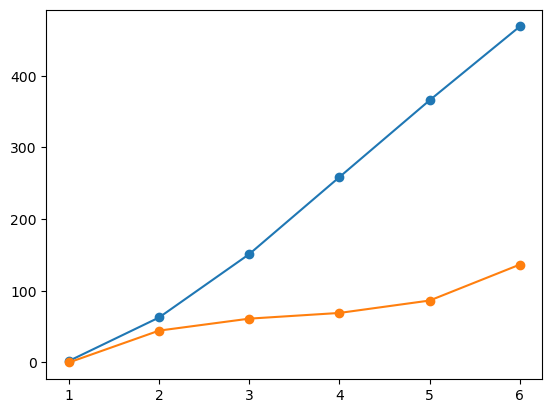

In [198]:
plt.plot(kl, train_error, marker='o')
plt.plot(kl, test_error, marker='o')

In [200]:
model = KNeighborsRegressor(n_neighbors=3)
model.fit(train_x, train_y)
pred = model.predict(test_x)

dfp['co2_library'] = pred
dfp

,co2,co2_pred_scratch,co2_library,error_scratch,error_lib
0,205,188.0,248.666667,17.0,78.777778
1,221,221.0,237.666667,0.0,58.555556
2,241,228.0,237.666667,13.0,31.222222
3,208,197.0,196.000000,11.0,9.888889
4,219,218.0,220.000000,1.0,8.333333
5,223,219.0,218.000000,4.0,9.333333


In [201]:
import numpy as np

In [202]:
dfp['error_scratch'] = np.abs(dfp['co2'] - dfp['co2_pred_scratch'])
dfp['error_lib'] = np.abs(dfp['co2'] - dfp['co2_library'])
dfp

,co2,co2_pred_scratch,co2_library,error_scratch,error_lib
0,205,188.0,248.666667,17.0,43.666667
1,221,221.0,237.666667,0.0,16.666667
2,241,228.0,237.666667,13.0,3.333333
3,208,197.0,196.000000,11.0,12.000000
4,219,218.0,220.000000,1.0,1.000000
5,223,219.0,218.000000,4.0,5.000000


In [203]:
dfp['error_scratch'].sum()

46.0

In [204]:
dfp['error_lib'].sum()

81.66666666666666